# K-Means Clustering: A Discovery-Based Learning Journey

## Overview
This notebook provides an interactive, discovery-based approach to understanding K-means clustering. All functions are defined at the beginning, followed by guided exploration sections.

### Learning Objectives:
- Understand the K-means algorithm intuitively
- Implement K-means from scratch
- Learn how to choose optimal K
- Explore limitations and real-world applications

## Part 0: All Function Definitions
All functions used throughout this notebook are defined here.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [25]:
# ============================================
# DATA GENERATION FUNCTIONS
# ============================================

def generate_sample_data(data_type='blobs', n_samples=300, n_features=2, 
                         n_clusters=3, noise=0.1, random_state=42):
    """Generate different types of sample data for clustering experiments."""
    np.random.seed(random_state)
    
    if data_type == 'blobs':
        X, y = make_blobs(n_samples=n_samples, n_features=n_features, 
                         centers=n_clusters, cluster_std=noise, random_state=random_state)
    elif data_type == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    elif data_type == 'circles':
        X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5, random_state=random_state)
    elif data_type == 'anisotropic':
        X, y = make_blobs(n_samples=n_samples, n_features=n_features, 
                         centers=n_clusters, random_state=random_state)
        transformation = [[0.6, -0.6], [-0.4, 0.8]]
        X = np.dot(X, transformation)
    elif data_type == 'varied_size':
        X, y = make_blobs(n_samples=n_samples, n_features=n_features,
                         centers=n_clusters, 
                         cluster_std=[0.5, 1.5, 2.0][:n_clusters],
                         random_state=random_state)
    else:
        raise ValueError(f"Unknown data type: {data_type}")
    
    return X, y

def create_interactive_data(n_points=100):
    """Allow users to create their own dataset interactively."""
    fig, ax = plt.subplots(figsize=(8, 6))
    points = []
    
    def on_click(event):
        if event.inaxes:
            points.append([event.xdata, event.ydata])
            ax.scatter(event.xdata, event.ydata, c='blue', s=50)
            plt.draw()
    
    fig.canvas.mpl_connect('button_press_event', on_click)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_title('Click to add data points')
    ax.grid(True, alpha=0.3)
    
    return fig, points

In [26]:
# ============================================
# K-MEANS IMPLEMENTATION FUNCTIONS
# ============================================

def initialize_centroids(X, k, method='random'):
    """Initialize k centroids using different methods."""
    n_samples = X.shape[0]
    
    if method == 'random':
        indices = np.random.choice(n_samples, k, replace=False)
        centroids = X[indices]
    elif method == 'kmeans++':
        centroids = [X[np.random.randint(n_samples)]]
        
        for _ in range(1, k):
            distances = np.array([min([np.linalg.norm(x - c)**2 for c in centroids]) for x in X])
            probabilities = distances / distances.sum()
            cumulative = probabilities.cumsum()
            r = np.random.rand()
            
            for j, p in enumerate(cumulative):
                if r < p:
                    centroids.append(X[j])
                    break
        
        centroids = np.array(centroids)
    else:
        raise ValueError(f"Unknown initialization method: {method}")
    
    return centroids

def assign_clusters(X, centroids):
    """Assign each point to the nearest centroid."""
    n_samples = X.shape[0]
    k = centroids.shape[0]
    
    distances = np.zeros((n_samples, k))
    for i, centroid in enumerate(centroids):
        distances[:, i] = np.linalg.norm(X - centroid, axis=1)
    
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, k):
    """Update centroids as the mean of assigned points."""
    centroids = np.zeros((k, X.shape[1]))
    
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            centroids[i] = cluster_points.mean(axis=0)
    
    return centroids

def kmeans_step_by_step(X, k, max_iters=100, tol=1e-4, init_method='random'):
    """K-means clustering with step-by-step history for visualization."""
    centroids = initialize_centroids(X, k, method=init_method)
    history = {'centroids': [centroids.copy()], 'labels': [], 'inertia': []}
    
    for iteration in range(max_iters):
        # Assign clusters
        labels = assign_clusters(X, centroids)
        history['labels'].append(labels.copy())
        
        # Calculate inertia
        inertia = calculate_inertia(X, centroids, labels)
        history['inertia'].append(inertia)
        
        # Update centroids
        new_centroids = update_centroids(X, labels, k)
        
        # Check convergence
        if np.allclose(centroids, new_centroids, atol=tol):
            break
        
        centroids = new_centroids
        history['centroids'].append(centroids.copy())
    
    return centroids, labels, history

In [27]:
# ============================================
# VISUALIZATION FUNCTIONS
# ============================================

def plot_clusters(X, labels=None, centroids=None, title='Clustering Result', ax=None):
    """Plot data points with optional cluster labels and centroids."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    if labels is None:
        ax.scatter(X[:, 0], X[:, 1], c='gray', s=50, alpha=0.6)
    else:
        scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, s=50, alpha=0.6, cmap='viridis')
        if ax.figure is not None:
            plt.colorbar(scatter, ax=ax)
    
    if centroids is not None:
        ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, 
                  marker='*', edgecolors='black', linewidth=2)
    
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.grid(True, alpha=0.3)
    
    return ax

def plot_iteration(X, history, iteration):
    """Plot a specific iteration of K-means."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot current state
    if iteration < len(history['labels']):
        labels = history['labels'][iteration]
        centroids = history['centroids'][min(iteration, len(history['centroids'])-1)]
        plot_clusters(X, labels, centroids, f'Iteration {iteration}', ax1)
    
    # Plot inertia over iterations
    ax2.plot(range(len(history['inertia'][:iteration+1])), 
             history['inertia'][:iteration+1], 'o-')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Inertia (Within-cluster sum of squares)')
    ax2.set_title('Convergence Progress')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def animate_kmeans(X, history, interval=500):
    """Create interactive animation of K-means iterations."""
    def update(iteration):
        clear_output(wait=True)
        plot_iteration(X, history, iteration)
        plt.show()
    
    iteration_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(history['labels'])-1,
        step=1,
        description='Iteration:',
        continuous_update=False
    )
    
    play_button = widgets.Play(
        value=0,
        min=0,
        max=len(history['labels'])-1,
        step=1,
        interval=interval,
        description="Play"
    )
    
    widgets.jslink((play_button, 'value'), (iteration_slider, 'value'))
    ui = widgets.HBox([play_button, iteration_slider])
    out = widgets.interactive_output(update, {'iteration': iteration_slider})
    
    display(ui, out)

In [28]:
# ============================================
# EVALUATION FUNCTIONS
# ============================================

def calculate_inertia(X, centroids, labels):
    """Calculate within-cluster sum of squares (inertia)."""
    inertia = 0
    for i, centroid in enumerate(centroids):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            inertia += np.sum((cluster_points - centroid) ** 2)
    return inertia

def elbow_method(X, k_range=range(2, 10)):
    """Perform elbow method to find optimal k."""
    inertias = []
    silhouettes = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, kmeans.labels_))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Elbow plot
    ax1.plot(k_range, inertias, 'bo-')
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method')
    ax1.grid(True, alpha=0.3)
    
    # Silhouette plot
    ax2.plot(k_range, silhouettes, 'ro-')
    ax2.set_xlabel('Number of clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, inertias, silhouettes

def silhouette_analysis(X, k_range=range(2, 6)):
    """Detailed silhouette analysis for different k values."""
    fig, axes = plt.subplots((len(k_range) + 1) // 2, 2, figsize=(14, 5*((len(k_range) + 1) // 2)))
    axes = axes.flatten()
    
    for idx, k in enumerate(k_range):
        ax = axes[idx]
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        
        silhouette_vals = silhouette_samples(X, labels)
        y_lower = 10
        
        for i in range(k):
            cluster_silhouette_vals = silhouette_vals[labels == i]
            cluster_silhouette_vals.sort()
            
            size_cluster_i = cluster_silhouette_vals.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = plt.cm.viridis(float(i) / k)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                            0, cluster_silhouette_vals,
                            facecolor=color, edgecolor=color, alpha=0.7)
            
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        
        ax.set_title(f'Silhouette plot for k={k}')
        ax.set_xlabel('Silhouette coefficient')
        ax.set_ylabel('Cluster')
        
        silhouette_avg = silhouette_score(X, labels)
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax.set_xlim([-0.1, 1])
    
    # Hide unused subplots
    for idx in range(len(k_range), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    return fig

In [6]:
# ============================================
# INTERACTIVE WIDGET FUNCTIONS
# ============================================

def interactive_kmeans_parameters():
    """Interactive widget to explore K-means parameters."""
    def update(data_type, n_clusters, n_samples, noise, init_method):
        X, y_true = generate_sample_data(data_type, n_samples=n_samples, 
                                         n_clusters=n_clusters, noise=noise)
        
        centroids, labels, history = kmeans_step_by_step(X, n_clusters, init_method=init_method)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Original data
        plot_clusters(X, y_true, None, 'True Clusters', axes[0])
        
        # K-means result
        plot_clusters(X, labels, centroids, 'K-means Result', axes[1])
        
        # Convergence
        axes[2].plot(history['inertia'], 'o-')
        axes[2].set_xlabel('Iteration')
        axes[2].set_ylabel('Inertia')
        axes[2].set_title('Convergence')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"Final inertia: {history['inertia'][-1]:.2f}")
        print(f"Converged in {len(history['inertia'])} iterations")
        
        if len(np.unique(labels)) > 1:
            score = silhouette_score(X, labels)
            print(f"Silhouette score: {score:.3f}")
    
    widgets.interact(update,
                    data_type=['blobs', 'moons', 'circles', 'anisotropic', 'varied_size'],
                    n_clusters=widgets.IntSlider(min=2, max=8, value=3, description='K:'),
                    n_samples=widgets.IntSlider(min=50, max=500, value=200, step=50, description='Samples:'),
                    noise=widgets.FloatSlider(min=0, max=2, value=0.5, step=0.1, description='Noise:'),
                    init_method=['random', 'kmeans++'])

def manual_centroid_placement():
    """Interactive manual centroid placement."""
    X, _ = generate_sample_data('blobs', n_samples=200, n_clusters=3)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot original data
    ax1.scatter(X[:, 0], X[:, 1], c='gray', s=50, alpha=0.6)
    ax1.set_title('Click to place centroids (up to 5)')
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax1.grid(True, alpha=0.3)
    
    centroids = []
    
    def on_click(event):
        if event.inaxes == ax1 and len(centroids) < 5:
            centroids.append([event.xdata, event.ydata])
            ax1.scatter(event.xdata, event.ydata, c='red', s=200, 
                       marker='*', edgecolors='black', linewidth=2)
            
            if len(centroids) >= 2:
                # Perform clustering with manual centroids
                manual_centroids = np.array(centroids)
                labels = assign_clusters(X, manual_centroids)
                
                ax2.clear()
                plot_clusters(X, labels, manual_centroids, 
                            f'Clustering with {len(centroids)} centroids', ax2)
            
            plt.draw()
    
    fig.canvas.mpl_connect('button_press_event', on_click)
    plt.show()
    
    return fig

In [7]:
# ============================================
# APPLICATION FUNCTIONS
# ============================================

def image_compression_demo(image_path=None, k_values=[2, 4, 8, 16, 32]):
    """Demonstrate K-means for image compression."""
    if image_path is None:
        # Create a synthetic image
        from matplotlib import patches
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
        
        # Add colorful shapes
        circle1 = patches.Circle((30, 30), 20, color='red')
        circle2 = patches.Circle((70, 70), 15, color='blue')
        rect = patches.Rectangle((50, 20), 30, 40, color='green')
        
        ax.add_patch(circle1)
        ax.add_patch(circle2)
        ax.add_patch(rect)
        
        ax.axis('off')
        
        # Convert to image array
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
    else:
        from PIL import Image
        image = np.array(Image.open(image_path))
    
    # Prepare image data
    image = image / 255.0  # Normalize
    original_shape = image.shape
    pixels = image.reshape(-1, 3)
    
    # Apply K-means with different K values
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Original image
    axes[0].imshow(image)
    axes[0].set_title(f'Original ({pixels.shape[0]} colors)')
    axes[0].axis('off')
    
    for idx, k in enumerate(k_values, 1):
        if idx < len(axes):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(pixels)
            compressed_pixels = kmeans.cluster_centers_[labels]
            compressed_image = compressed_pixels.reshape(original_shape)
            
            axes[idx].imshow(compressed_image)
            axes[idx].set_title(f'K={k} colors')
            axes[idx].axis('off')
            
            # Calculate compression ratio
            original_size = pixels.shape[0] * pixels.shape[1]
            compressed_size = k * pixels.shape[1] + pixels.shape[0]
            ratio = original_size / compressed_size
            axes[idx].text(0.5, -0.1, f'Compression: {ratio:.1f}x', 
                          transform=axes[idx].transAxes, ha='center')
    
    plt.suptitle('Image Compression using K-means', fontsize=16)
    plt.tight_layout()
    return fig

def customer_segmentation_demo():
    """Simulate customer segmentation with K-means."""
    np.random.seed(42)
    
    # Generate synthetic customer data
    n_customers = 500
    
    # Feature engineering
    # Group 1: High value, low frequency
    group1 = np.random.multivariate_normal([80, 20], [[100, 50], [50, 100]], 150)
    # Group 2: Low value, high frequency
    group2 = np.random.multivariate_normal([20, 80], [[150, -50], [-50, 100]], 150)
    # Group 3: Medium value, medium frequency
    group3 = np.random.multivariate_normal([50, 50], [[200, 0], [0, 200]], 200)
    
    X = np.vstack([group1, group2, group3])
    X = np.clip(X, 0, 100)  # Ensure positive values
    
    feature_names = ['Purchase Value (avg $)', 'Purchase Frequency (per month)']
    
    # Perform clustering
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Scatter plot
    scatter = axes[0].scatter(X[:, 0], X[:, 1], c=labels, s=50, alpha=0.6, cmap='viridis')
    axes[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
                   c='red', s=200, marker='*', edgecolors='black', linewidth=2)
    axes[0].set_xlabel(feature_names[0])
    axes[0].set_ylabel(feature_names[1])
    axes[0].set_title('Customer Segments')
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[0])
    
    # Segment characteristics
    segment_names = ['Premium', 'Frequent', 'Regular']
    segment_data = []
    
    for i in range(3):
        mask = labels == i
        segment_data.append([
            np.mean(X[mask, 0]),
            np.mean(X[mask, 1]),
            np.sum(mask)
        ])
    
    segment_df = np.array(segment_data)
    
    # Bar plot for average values
    x = np.arange(3)
    width = 0.35
    
    axes[1].bar(x - width/2, segment_df[:, 0], width, label=feature_names[0])
    axes[1].bar(x + width/2, segment_df[:, 1], width, label=feature_names[1])
    axes[1].set_xlabel('Segment')
    axes[1].set_ylabel('Average Value')
    axes[1].set_title('Segment Characteristics')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(segment_names)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Pie chart for segment sizes
    axes[2].pie(segment_df[:, 2], labels=segment_names, autopct='%1.1f%%', startangle=90)
    axes[2].set_title('Segment Distribution')
    
    plt.suptitle('Customer Segmentation Analysis', fontsize=16)
    plt.tight_layout()
    
    # Print segment summaries
    print("\nSegment Analysis:")
    print("="*50)
    for i, name in enumerate(segment_names):
        print(f"\n{name} Segment (Cluster {i}):")
        print(f"  - Size: {int(segment_df[i, 2])} customers ({segment_df[i, 2]/len(X)*100:.1f}%)")
        print(f"  - Avg Purchase Value: ${segment_df[i, 0]:.2f}")
        print(f"  - Avg Purchase Frequency: {segment_df[i, 1]:.1f} per month")
        print(f"  - Estimated Monthly Revenue: ${segment_df[i, 0] * segment_df[i, 1]:.2f}")
    
    return fig, X, labels

# Section 1: Introduction & Data Exploration

## Let's start by exploring different types of data!

K-means clustering is an unsupervised learning algorithm that groups similar data points together. Before we dive into the algorithm, let's explore different types of data patterns.

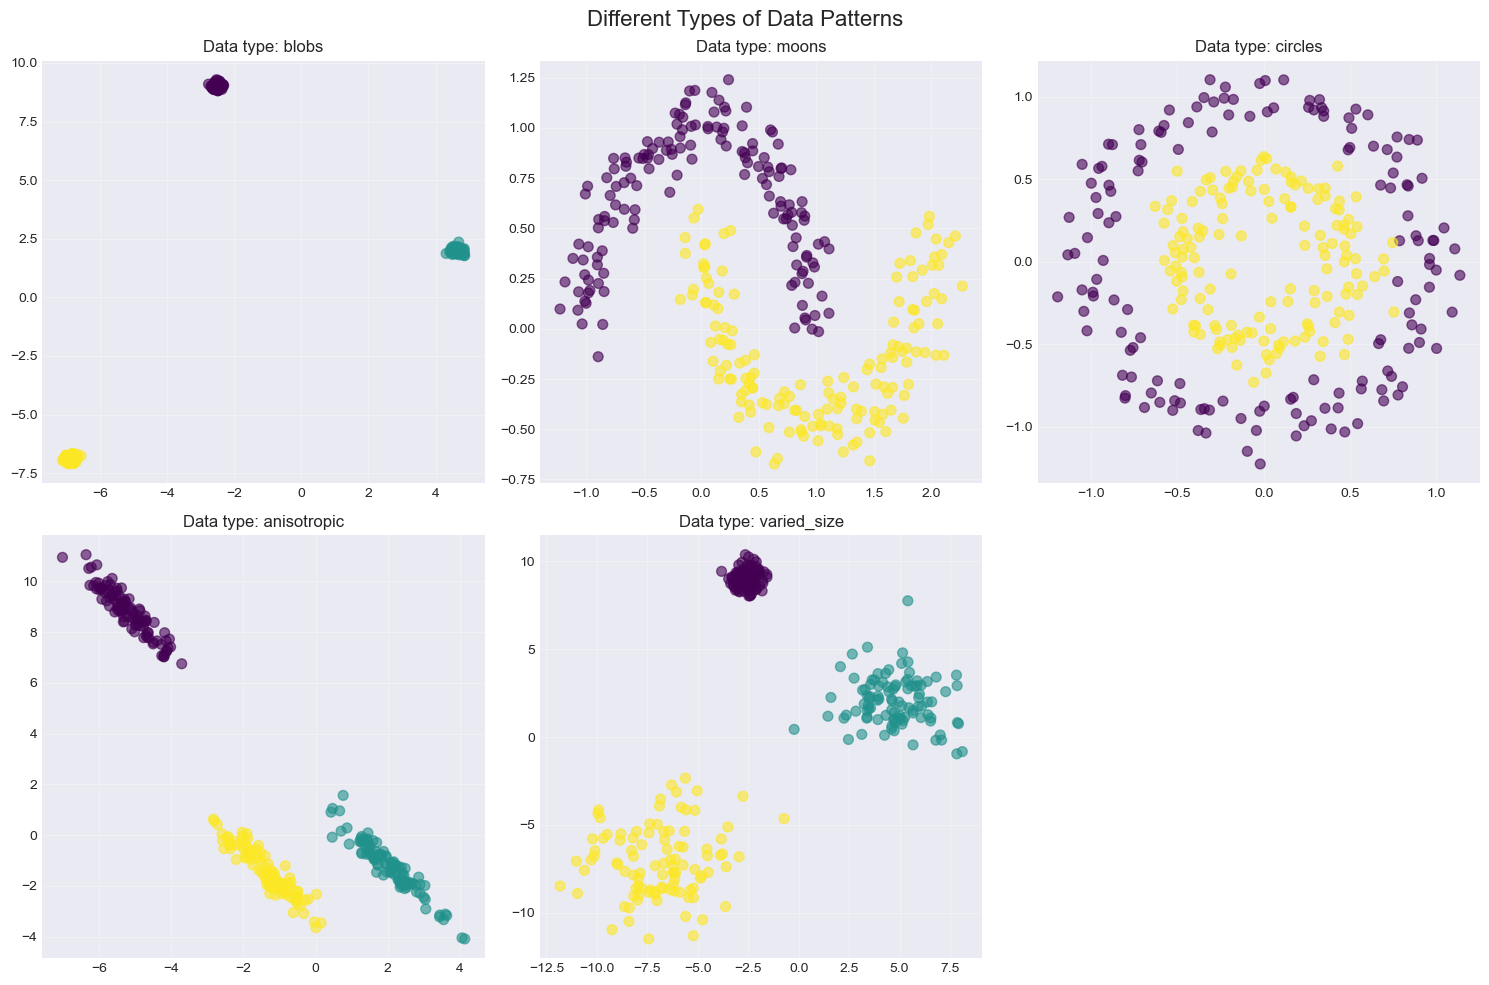


Discovery Questions:
1. Which data patterns look easiest to cluster?
2. Which might be challenging for K-means?
3. What makes some patterns harder than others?


In [30]:
# Explore different data types
data_types = ['blobs', 'moons', 'circles', 'anisotropic', 'varied_size']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, data_type in enumerate(data_types):
    X, y = generate_sample_data(data_type, n_samples=300)
    axes[idx].scatter(X[:, 0], X[:, 1], c=y, s=50, alpha=0.6, cmap='viridis')
    axes[idx].set_title(f'Data type: {data_type}')
    axes[idx].grid(True, alpha=0.3)

# Hide the last subplot
fig.delaxes(axes[5])
plt.suptitle('Different Types of Data Patterns', fontsize=16)
plt.tight_layout()
plt.show()

print("\nDiscovery Questions:")
print("1. Which data patterns look easiest to cluster?")
print("2. Which might be challenging for K-means?")
print("3. What makes some patterns harder than others?")

### Interactive Exploration
Try different parameters and see how they affect the data distribution!

In [32]:
# Interactive data generation
@widgets.interact(
    data_type=['moons', 'blobs', 'circles', 'anisotropic', 'varied_size'],
    n_samples=widgets.IntSlider(min=50, max=500, value=500, step=50),
    noise=widgets.FloatSlider(min=0, max=2, value=0.9, step=0.1)
)
def explore_data(data_type, n_samples, noise):
    X, y = generate_sample_data(data_type, n_samples=n_samples, noise=noise)
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, alpha=0.6, cmap='viridis')
    plt.title(f'{data_type} with {n_samples} samples and noise={noise}')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Data shape: {X.shape}")
    print(f"Number of natural clusters: {len(np.unique(y))}")

interactive(children=(Dropdown(description='data_type', options=('blobs', 'moons', 'circles', 'anisotropic', '…

# Section 2: Understanding K-Means Algorithm

## The K-Means Algorithm Step by Step

K-means follows these simple steps:
1. **Initialize** K centroids (cluster centers)
2. **Assign** each point to the nearest centroid
3. **Update** centroids to the mean of assigned points
4. **Repeat** steps 2-3 until convergence

Let's visualize this process!

In [48]:
# Generate simple data for demonstration
X_demo, y_demo = generate_sample_data('moons', n_samples=500, n_clusters=2, noise=0.5)

# Run K-means step by step
centroids, labels, history = kmeans_step_by_step(X_demo, k=2, init_method='random')

print(f"Algorithm converged in {len(history['inertia'])} iterations")
print(f"Final inertia: {history['inertia'][-1]:.2f}")

# Animate the K-means process
print("\nUse the slider below to see how K-means progresses:")
animate_kmeans(X_demo, history)

Algorithm converged in 7 iterations
Final inertia: 400.07

Use the slider below to see how K-means progresses:


Output()

### Centroid Initialization Methods

The initial position of centroids can significantly affect the final result. Let's compare different initialization methods:

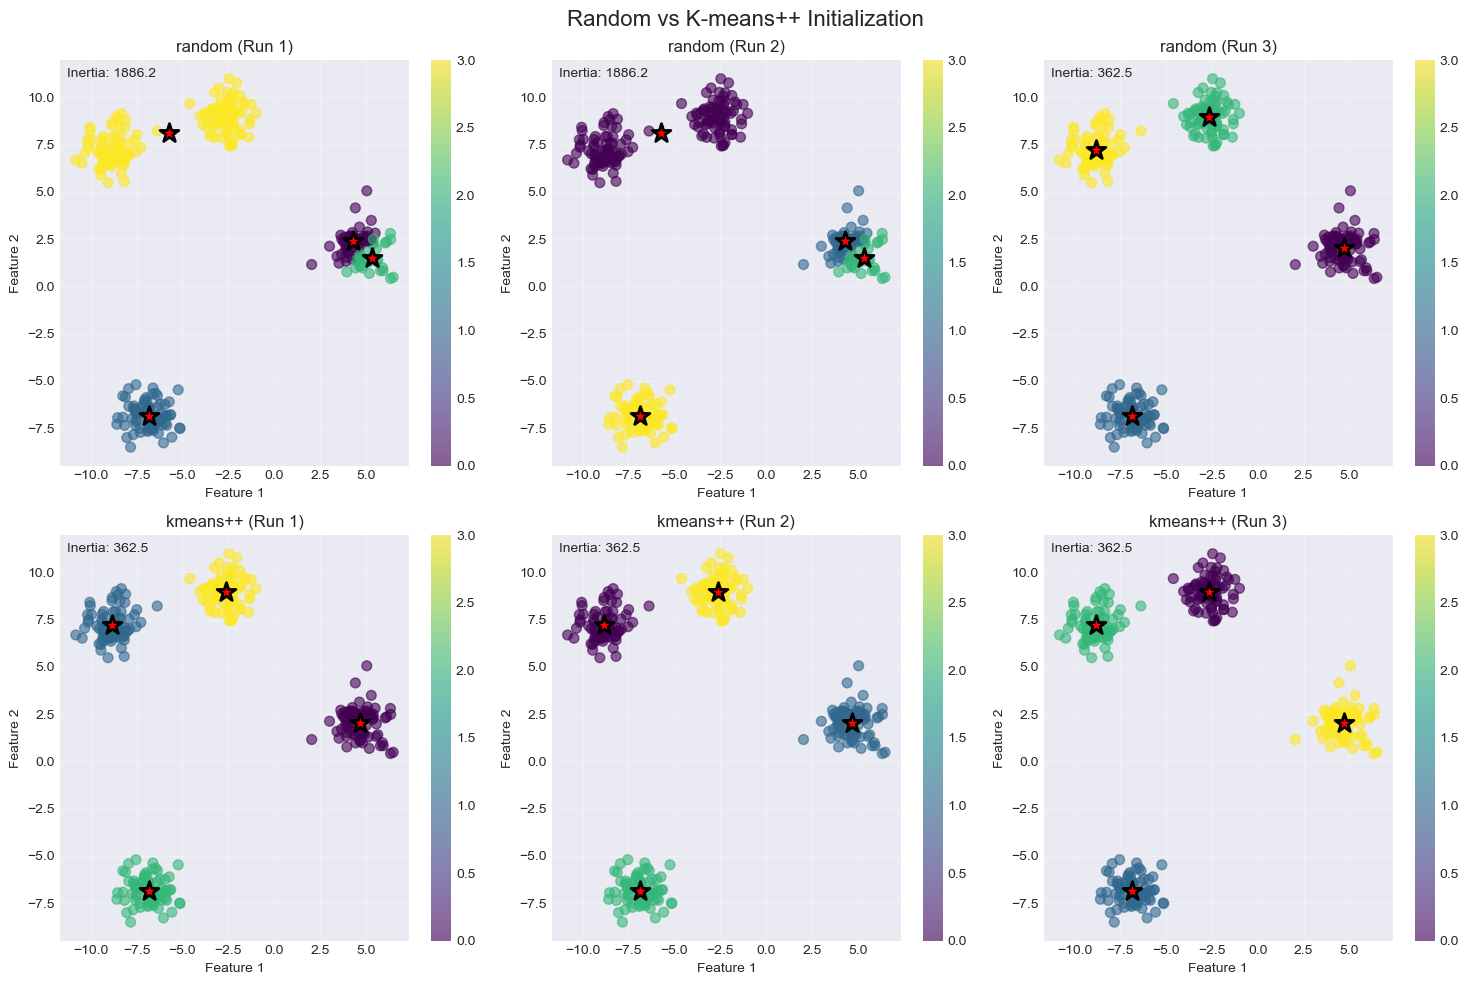


Observations:
- Random initialization can lead to different results each time
- K-means++ tends to produce more consistent and better results
- Lower inertia generally indicates better clustering


In [38]:
# Compare initialization methods
X_init, _ = generate_sample_data('blobs', n_samples=300, n_clusters=4, noise=0.8)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    row = i // 3
    col = i % 3
    
    method = 'random' if i < 3 else 'kmeans++'
    centroids, labels, history = kmeans_step_by_step(X_init, k=4, init_method=method)
    
    plot_clusters(X_init, labels, centroids, 
                 f'{method} (Run {(i%3)+1})', axes[row, col])
    axes[row, col].text(0.02, 0.98, f'Inertia: {history["inertia"][-1]:.1f}',
                       transform=axes[row, col].transAxes,
                       verticalalignment='top')

plt.suptitle('Random vs K-means++ Initialization', fontsize=16)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Random initialization can lead to different results each time")
print("- K-means++ tends to produce more consistent and better results")
print("- Lower inertia generally indicates better clustering")

# Section 3: Implementation from Scratch



### Interactive Algorithm Exploration

Experiment with different parameters to see how they affect the clustering!

In [40]:
interactive_kmeans_parameters()

interactive(children=(Dropdown(description='data_type', options=('blobs', 'moons', 'circles', 'anisotropic', '…

# Section 4: Choosing Optimal K

## The Million Dollar Question: How many clusters?

One of the biggest challenges in K-means is choosing the right number of clusters. Let's explore methods to find the optimal K.

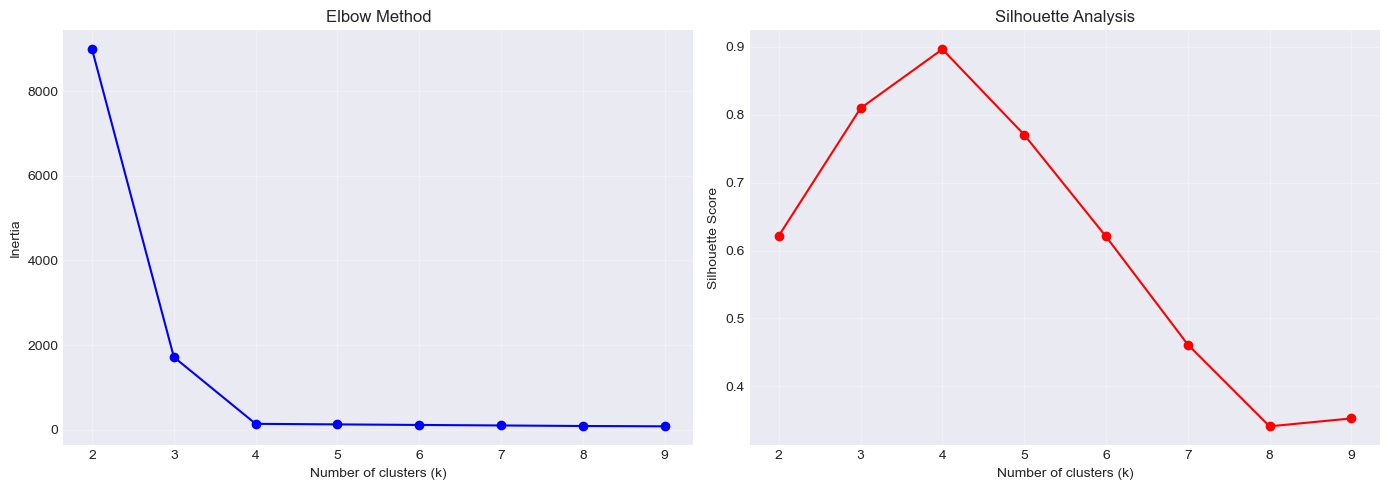


Interpretation:
- Elbow Method: Look for the 'elbow' where inertia stops decreasing rapidly
- Silhouette Score: Higher is better (max = 1.0)

Based on these plots, what would you choose as the optimal K?


In [41]:
# Generate data with known number of clusters
X_elbow, _ = generate_sample_data('blobs', n_samples=300, n_clusters=4, noise=0.5)

# Elbow method and silhouette analysis
fig, inertias, silhouettes = elbow_method(X_elbow, k_range=range(2, 10))
plt.show()

print("\nInterpretation:")
print("- Elbow Method: Look for the 'elbow' where inertia stops decreasing rapidly")
print("- Silhouette Score: Higher is better (max = 1.0)")
print("\nBased on these plots, what would you choose as the optimal K?")

### Detailed Silhouette Analysis

Silhouette plots show how well each point fits within its cluster:

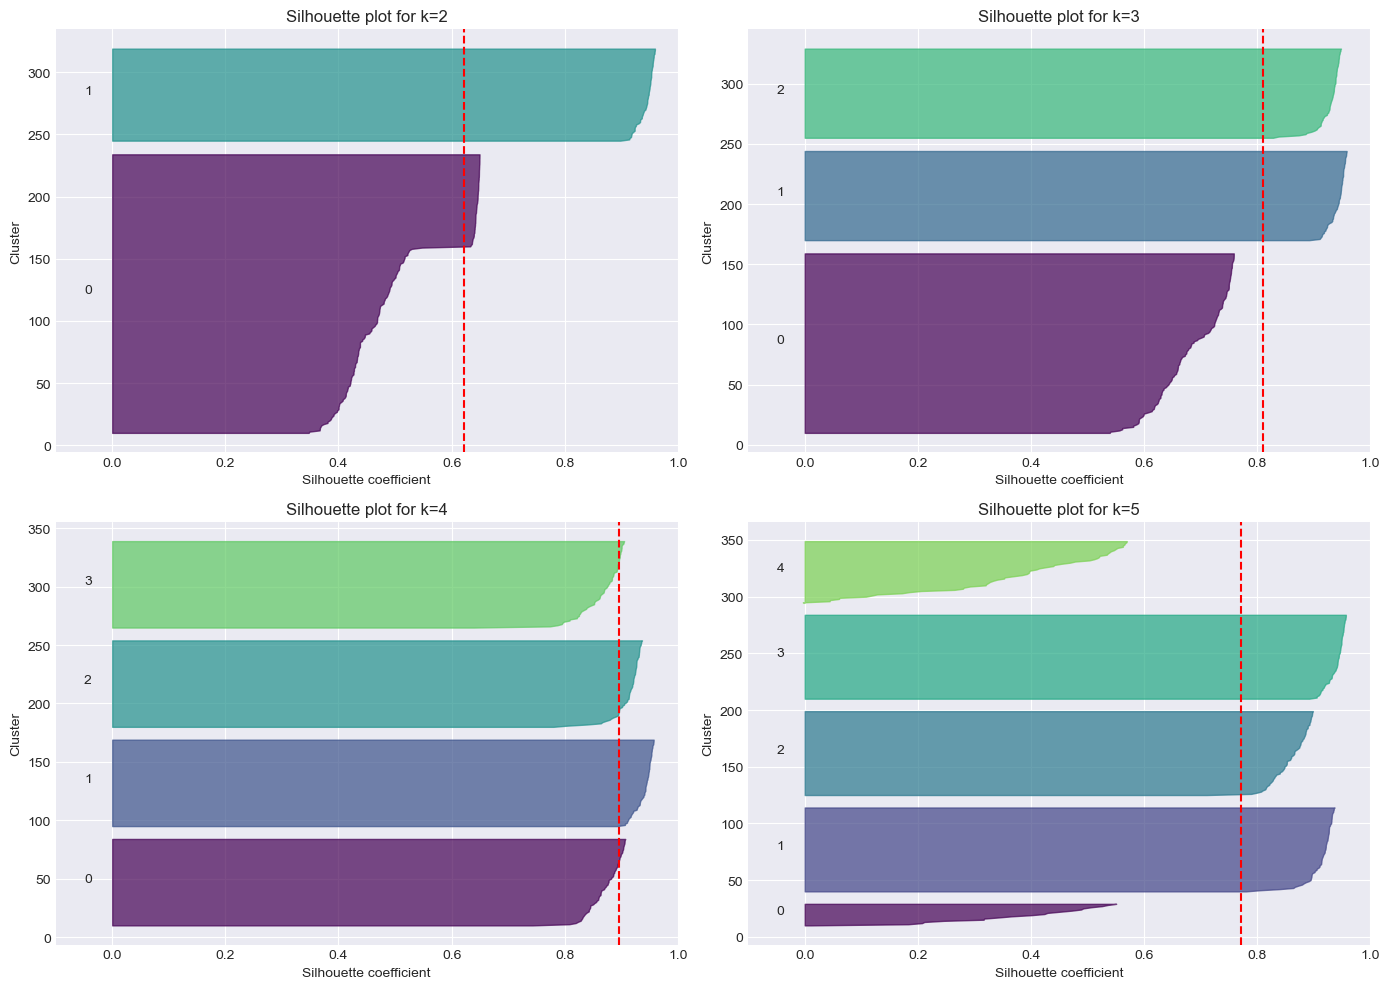


How to read silhouette plots:
- Width of each cluster shows the number of points
- Length shows silhouette coefficient (longer = better fit)
- Red line shows average silhouette score
- Uniform cluster widths suggest balanced clustering


In [16]:
# Detailed silhouette analysis
fig = silhouette_analysis(X_elbow, k_range=range(2, 6))
plt.show()

print("\nHow to read silhouette plots:")
print("- Width of each cluster shows the number of points")
print("- Length shows silhouette coefficient (longer = better fit)")
print("- Red line shows average silhouette score")
print("- Uniform cluster widths suggest balanced clustering")

### Discovery Exercise: Finding K in Mystery Data

Can you determine the optimal number of clusters in this mystery dataset?

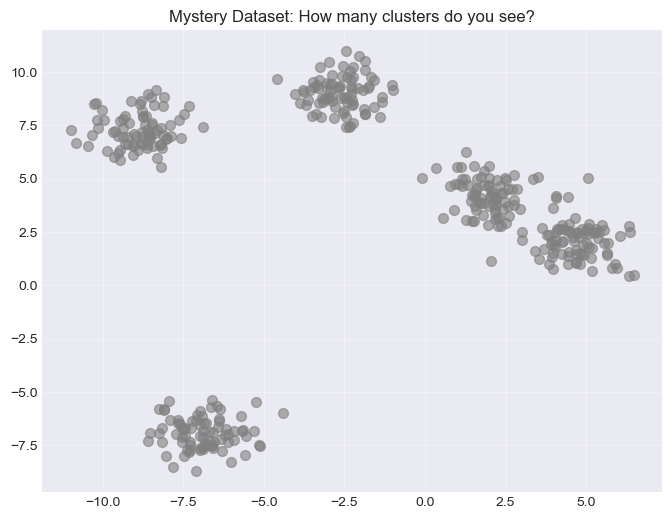

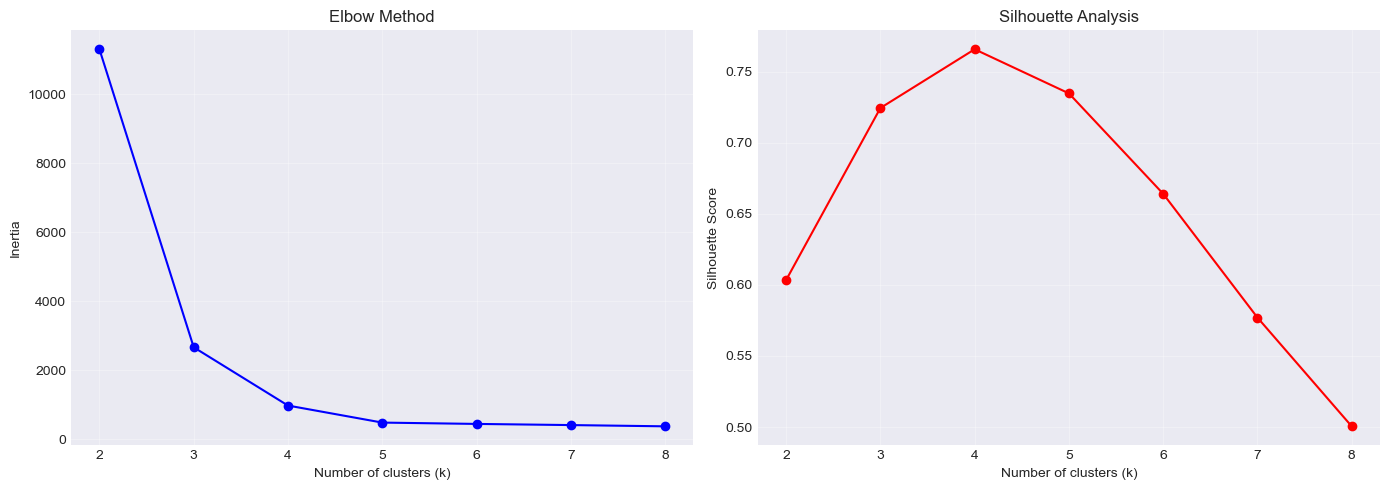


The mystery dataset has 5 clusters!
Did your analysis correctly identify it?


In [42]:
# Mystery data
np.random.seed(123)
mystery_k = np.random.randint(3, 7)
X_mystery, _ = generate_sample_data('blobs', n_samples=400, n_clusters=mystery_k, noise=0.8)

# Shuffle to hide structure
shuffle_idx = np.random.permutation(len(X_mystery))
X_mystery = X_mystery[shuffle_idx]

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X_mystery[:, 0], X_mystery[:, 1], c='gray', s=50, alpha=0.6)
plt.title('Mystery Dataset: How many clusters do you see?')
plt.grid(True, alpha=0.3)
plt.show()

# Your analysis
fig, inertias, silhouettes = elbow_method(X_mystery, k_range=range(2, 9))
plt.show()

print(f"\nThe mystery dataset has {mystery_k} clusters!")
print("Did your analysis correctly identify it?")

# Section 5: Challenges & Limitations

## When K-Means Struggles

K-means makes assumptions about data that aren't always true. Let's explore its limitations!

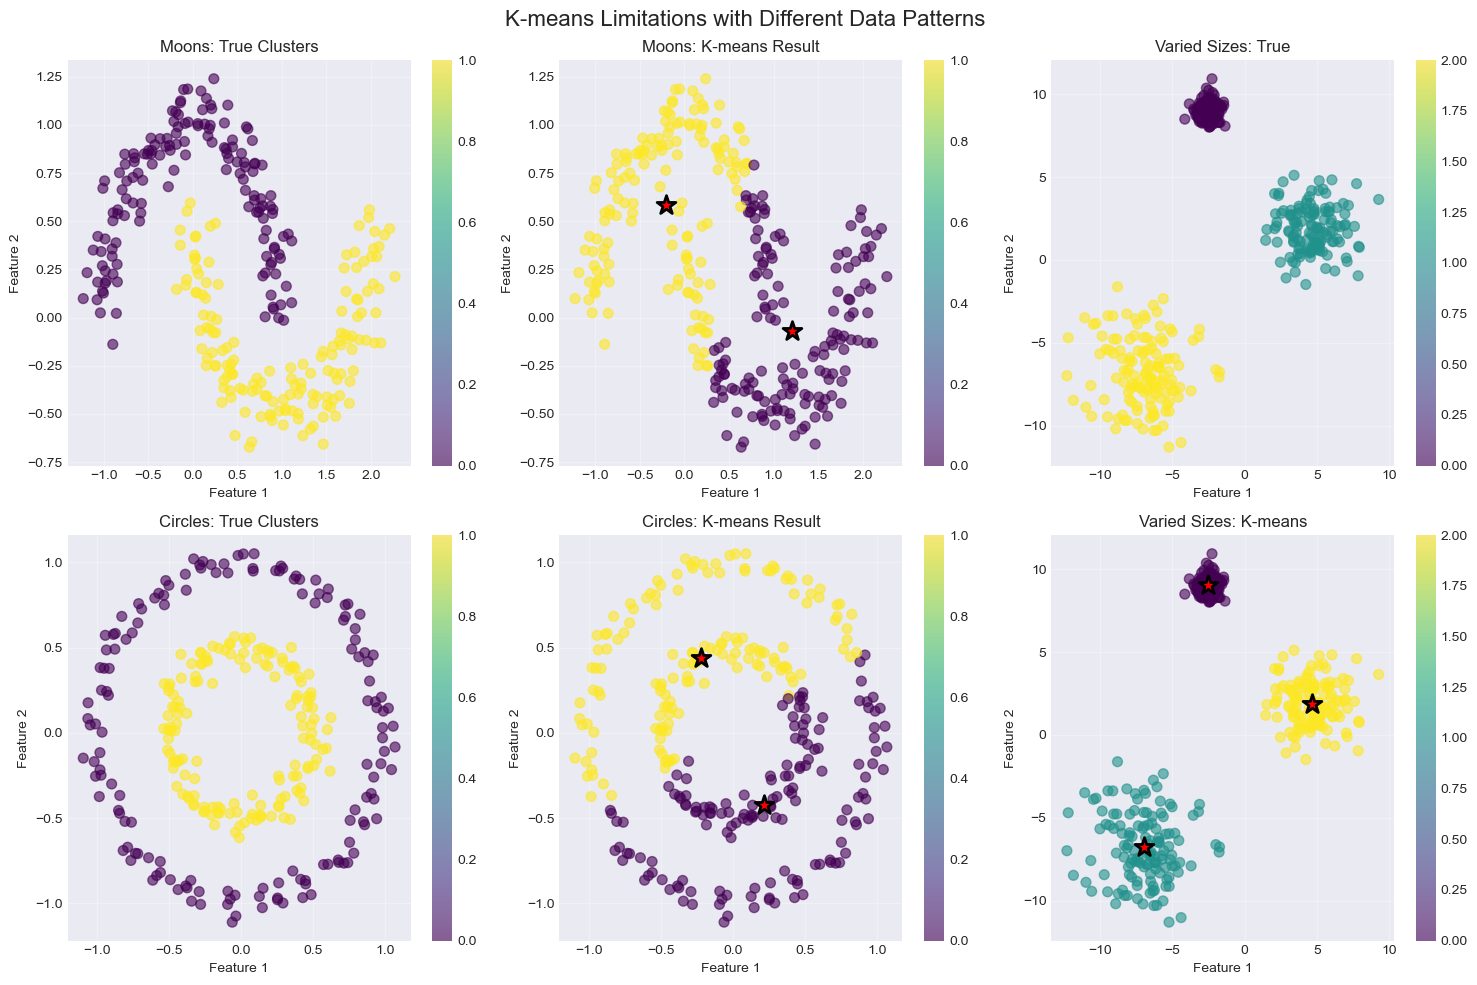


Key Observations:
1. K-means assumes spherical clusters
2. It struggles with non-convex shapes (moons, circles)
3. All clusters are treated equally regardless of size/density
4. K-means finds cluster centers, which may not represent non-spherical clusters well


In [43]:
# Challenge 1: Non-spherical clusters
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Moons
X_moons, y_moons = generate_sample_data('moons', n_samples=300, noise=0.1)
kmeans_moons = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_moons = kmeans_moons.fit_predict(X_moons)

plot_clusters(X_moons, y_moons, None, 'Moons: True Clusters', axes[0, 0])
plot_clusters(X_moons, labels_moons, kmeans_moons.cluster_centers_, 
             'Moons: K-means Result', axes[0, 1])

# Circles
X_circles, y_circles = generate_sample_data('circles', n_samples=300, noise=0.05)
kmeans_circles = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_circles = kmeans_circles.fit_predict(X_circles)

plot_clusters(X_circles, y_circles, None, 'Circles: True Clusters', axes[1, 0])
plot_clusters(X_circles, labels_circles, kmeans_circles.cluster_centers_, 
             'Circles: K-means Result', axes[1, 1])

# Challenge 2: Different cluster sizes/densities
X_varied, y_varied = generate_sample_data('varied_size', n_samples=400, n_clusters=3)
kmeans_varied = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_varied = kmeans_varied.fit_predict(X_varied)

plot_clusters(X_varied, y_varied, None, 'Varied Sizes: True', axes[0, 2])
plot_clusters(X_varied, labels_varied, kmeans_varied.cluster_centers_, 
             'Varied Sizes: K-means', axes[1, 2])

plt.suptitle('K-means Limitations with Different Data Patterns', fontsize=16)
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("1. K-means assumes spherical clusters")
print("2. It struggles with non-convex shapes (moons, circles)")
print("3. All clusters are treated equally regardless of size/density")
print("4. K-means finds cluster centers, which may not represent non-spherical clusters well")

### Sensitivity to Scale

K-means is sensitive to the scale of features. Let's see why normalization matters!

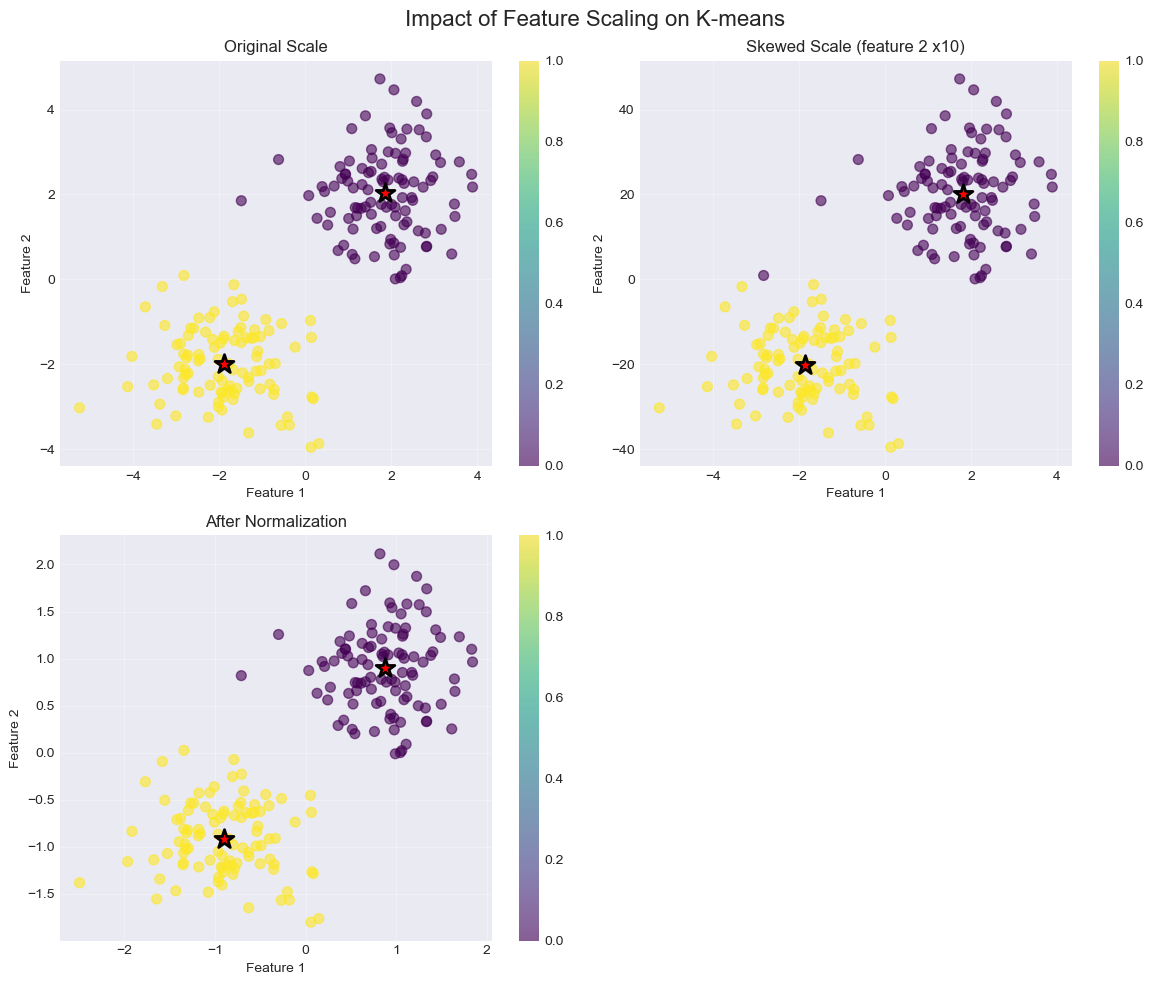


Lesson: Always normalize your features before applying K-means!
Different scales can make one feature dominate the distance calculations.


In [44]:
# Create data with different scales
np.random.seed(42)
X_scale = np.random.randn(200, 2)
X_scale[:100, 0] += 2
X_scale[100:, 0] -= 2
X_scale[:100, 1] += 2
X_scale[100:, 1] -= 2

# Scale second feature differently
X_scale_skewed = X_scale.copy()
X_scale_skewed[:, 1] *= 10  # Scale second feature by 10x

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original scale
kmeans_orig = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_orig = kmeans_orig.fit_predict(X_scale)
plot_clusters(X_scale, labels_orig, kmeans_orig.cluster_centers_, 
             'Original Scale', axes[0, 0])

# Skewed scale
kmeans_skewed = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_skewed = kmeans_skewed.fit_predict(X_scale_skewed)
plot_clusters(X_scale_skewed, labels_skewed, kmeans_skewed.cluster_centers_, 
             'Skewed Scale (feature 2 x10)', axes[0, 1])

# Normalized data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_scale_skewed)
kmeans_norm = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_norm = kmeans_norm.fit_predict(X_normalized)
plot_clusters(X_normalized, labels_norm, kmeans_norm.cluster_centers_, 
             'After Normalization', axes[1, 0])

# Hide last subplot
fig.delaxes(axes[1, 1])

plt.suptitle('Impact of Feature Scaling on K-means', fontsize=16)
plt.tight_layout()
plt.show()

print("\nLesson: Always normalize your features before applying K-means!")
print("Different scales can make one feature dominate the distance calculations.")

# Section 6: Real-World Applications



## Application 2: Customer Segmentation

Businesses use K-means to identify customer segments for targeted marketing!


Segment Analysis:

Premium Segment (Cluster 0):
  - Size: 151 customers (30.2%)
  - Avg Purchase Value: $19.07
  - Avg Purchase Frequency: 80.0 per month
  - Estimated Monthly Revenue: $1525.14

Frequent Segment (Cluster 1):
  - Size: 172 customers (34.4%)
  - Avg Purchase Value: $78.70
  - Avg Purchase Frequency: 22.5 per month
  - Estimated Monthly Revenue: $1767.25

Regular Segment (Cluster 2):
  - Size: 177 customers (35.4%)
  - Avg Purchase Value: $48.84
  - Avg Purchase Frequency: 53.1 per month
  - Estimated Monthly Revenue: $2592.17


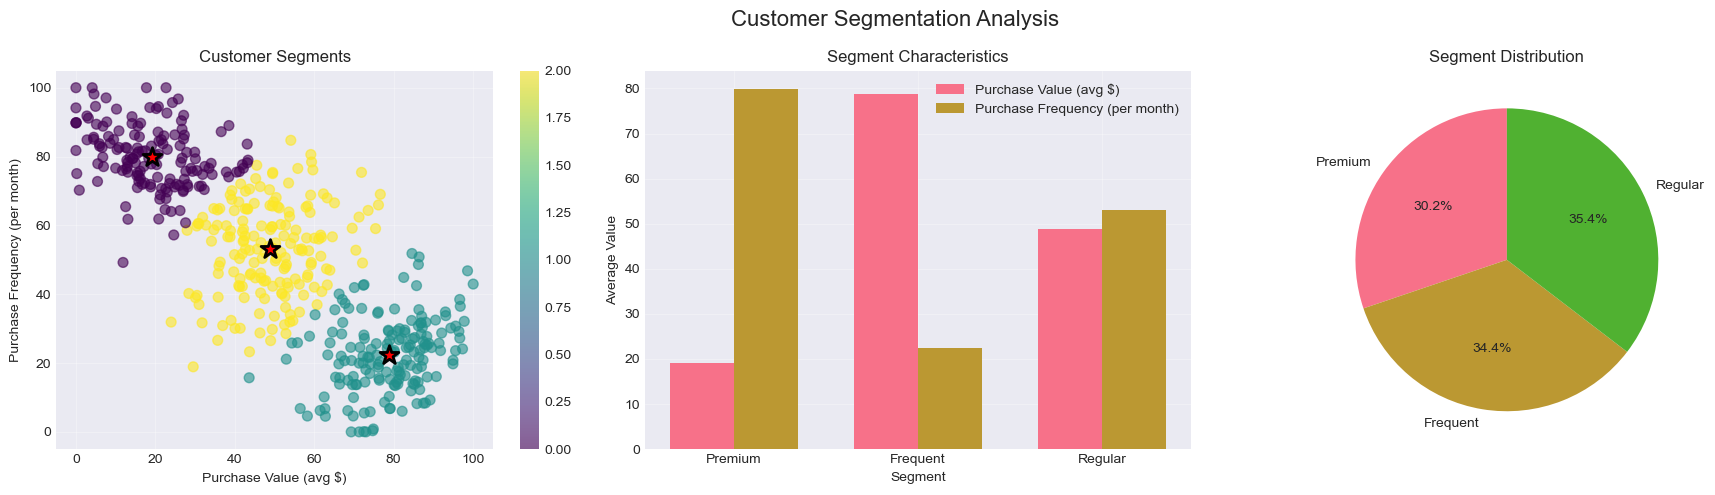

In [21]:
# Customer segmentation demo
fig, X_customers, customer_labels = customer_segmentation_demo()
plt.show()

# Summary & Next Steps

## What We've Learned

### Key Concepts:
1. **K-means Algorithm**: Simple, iterative clustering approach
2. **Initialization Matters**: K-means++ usually outperforms random initialization
3. **Choosing K**: Use elbow method and silhouette analysis
4. **Limitations**: Assumes spherical clusters, sensitive to scale
5. **Applications**: Image compression, customer segmentation, and more

### When to Use K-means:
- Well-separated spherical clusters
- Similar-sized clusters
- Large datasets (it's fast!)
- When K is known or can be estimated

### When to Consider Alternatives:
- Non-spherical clusters → DBSCAN
- Hierarchical structure → Agglomerative Clustering
- Unknown K → Mean Shift, DBSCAN
- Mixed data types → K-Prototypes

## Practice Exercises

1. **Easy**: Generate a dataset with 5 clusters and apply K-means with different K values (3, 5, 7). Compare results.

2. **Medium**: Implement a function that automatically finds the optimal K using the elbow method (hint: look for the point of maximum curvature).

3. **Hard**: Create a 2D dataset where K-means fails badly. Then implement a preprocessing step that makes K-means work better.

4. **Project**: Use K-means to segment an image of your choice. Experiment with different color spaces (RGB, HSV, Lab).

## Further Reading

- Original K-means paper: MacQueen, J. (1967)
- K-means++: Arthur & Vassilvitskii (2007)
- Comparison of clustering algorithms: Scikit-learn documentation
- Advanced topics: Mini-batch K-means, Kernel K-means